INITIAL SETUP I: INSTALLING PACKAGES

In [1]:
# Install necessary packages
!pip install dlib imutils imageio kaggle seaborn tensorflow scikit-image kagglehub

INITIAL SETUP II: IMPORTING LIBRARIES

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import cv2
import dlib
import imutils
import imageio
from imutils import face_utils
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import time


INITIAL SETUP III: SETTING UP MODEL FILES AND RETIREVING DATASET

In [3]:

# Ensure the dataset and model file are accessible
!mkdir -p /content/dataset
!mkdir -p /content/models

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d apoorvwatsky/miraclvc1 -p /content/dataset --unzip

# Download dataset
import kagglehub
dataset_path = kagglehub.dataset_download("apoorvwatsky/miraclvc1")
dataset_dir = "/root/.cache/kagglehub/datasets/apoorvwatsky/miraclvc1/versions/3/dataset/dataset"
predictor_path = "/root/.cache/kagglehub/datasets/apoorvwatsky/miraclvc1/versions/3/shape_predictor_68_face_landmarks.dat"

if not os.path.exists(dataset_dir) or not os.path.exists(predictor_path):
    raise FileNotFoundError("Dataset directory or shape predictor file not found.")

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/apoorvwatsky/miraclvc1
License(s): unknown
100% 5.12G/5.13G [01:05<00:00, 142MB/s]
100% 5.13G/5.13G [01:05<00:00, 83.6MB/s]


100%|██████████| 5.13G/5.13G [01:12<00:00, 75.8MB/s]

Extracting files...


In [4]:
#DO NOT RUN ONLY FOR HOST USE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA MANIPULATION I: DEFINING DATA MANIPULATION FUNCTIONS

In [5]:
# Functions for face cropping
def rect_to_bb(rect):
    x, y, w, h = rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top()
    return x, y, w, h

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def crop_and_save_image(img, img_path, write_img_path, img_name, predictor):

        # Load the input image and preprocess it
    detector = dlib.get_frontal_face_detector()
    image = imutils.resize(cv2.imread(img_path), width=500)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray_image, 1)
    if len(faces) != 1:
        print(f"ERROR: Detected {len(faces)} faces.")
        return

    # Get the facial landmarks for the detected face
    landmarks = predictor(gray_image, faces[0])
    points = face_utils.shape_to_np(landmarks)

    # Extract the region of interest (ROI) for the mouth
    x, y, w, h = cv2.boundingRect(np.array([points[48:68]]))
    mouth_roi = imutils.resize(gray_image[y:y + h, x:x + w], width=250)

    # Ensure the output directory exists and save the cropped image
    os.makedirs(os.path.dirname(write_img_path), exist_ok=True)
    cv2.imwrite(write_img_path, mouth_roi)

DATA MANIPULATION II: DEFINING DATASET

In [6]:
# Dataset
people = ['F01', 'F02', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'M01', 'M02', 'M04', 'M07', 'M08']
data_types = ['words']
folder_enum = ['01', '02', '05','07','08','10']
instances = ['01', '02']
words = ['Begin', 'Choose', 'Next',  'Start', 'Stop',  'Web']

DATA MANIPULATION III: CROPING EACH PERSON

In [ ]:

def crop_one_person():
    for person_ID in people:
        for data_type in data_types:
            for phrase_ID in folder_enum:
                for instance_ID in instances:
                    directory = os.path.join(dataset_dir, person_ID, data_type, phrase_ID, instance_ID)
                    cropped_dir = f'cropped/{person_ID}/{data_type}/{phrase_ID}/{instance_ID}/'
                    os.makedirs(cropped_dir, exist_ok=True)
                    filelist = os.listdir(directory)
                    for img_name in filelist:
                        if img_name.startswith('color'):
                            image = imageio.imread(os.path.join(directory, img_name))
                            crop_and_save_image(
                                image,
                                os.path.join(directory, img_name),
                                os.path.join(cropped_dir, img_name),
                                img_name,
                                dlib.shape_predictor(predictor_path)
                            )

# Crop all images
crop_one_person()

DATA MANIPULATION IV: PREPARE DATA FOR TRAINING

In [7]:
max_seq_length = 22
MAX_WIDTH, MAX_HEIGHT = 100, 100
UNSEEN_VALIDATION_SPLIT = ['F07', 'M02']
UNSEEN_TEST_SPLIT = ['F04', 'M01']

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

#change to the cropped directory

directory = "/content/drive/MyDrive/CV_Final Submission/cropped"
for person_id in people:
    for data_type in data_types:
        for word_index, word in enumerate(folder_enum):
            for iteration in instances:
                path = os.path.join(directory, person_id, data_type, word, iteration)
                filelist = sorted(os.listdir(path))
                sequence = []
                for img_name in filelist:
                    if img_name.startswith('color'):
                        image = imageio.imread(os.path.join(path, img_name))
                        image = resize(image, (MAX_WIDTH, MAX_HEIGHT))
                        image = (255 * image).astype(np.uint8)
                        sequence.append(image)
                pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))] * (max_seq_length - len(sequence))
                sequence.extend(pad_array)
                if person_id in UNSEEN_TEST_SPLIT:
                    X_test.append(sequence)
                    y_test.append(word_index)
                elif person_id in UNSEEN_VALIDATION_SPLIT:
                    X_val.append(sequence)
                    y_val.append(word_index)
                else:
                    X_train.append(sequence)
                    y_train.append(word_index)

X_train, X_val, X_test = map(np.array, (X_train, X_val, X_test))
y_train, y_val, y_test = map(lambda y: to_categorical(y, 10), (y_train, y_val, y_test))

X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)

<ipython-input-7-51a011194463>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(path, img_name))


MODEL CREATION

In [25]:
# Model definition using EfficientNet
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class EnhancedLipNetWithEfficientNet(Model):
    def __init__(self, num_classes=10, dropout_rate=0.3, num_heads=4, key_dim=64,trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.num_heads = num_heads
        self.key_dim = key_dim


        self.efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        self.efficientnet.trainable = False
        self.lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        batch_size, time_steps, height, width, channels = tf.unstack(tf.shape(inputs))
        inputs_rgb = tf.reshape(inputs, [-1, height, width, channels])
        inputs_rgb = tf.image.grayscale_to_rgb(inputs_rgb)
        x = self.efficientnet(inputs_rgb)
        x = tf.reduce_mean(x, axis=[1, 2])
        feature_dim = x.shape[-1]
        x = tf.reshape(x, [batch_size, time_steps, feature_dim])
        x = self.lstm(x)
        x = self.attention(x, x)
        x = tf.reduce_mean(x, axis=1)
        return self.fc(x)
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "dropout_rate": self.dropout_rate,
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)



# Initialize and compile the model
model = EnhancedLipNetWithEfficientNet(num_classes=10)
model.build(input_shape=(None, 22, 100, 100, 1))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'enhanced_lip_net_with_efficient_net_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "enhanced_lip_net_with_efficient_net_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention_4               │ ?                           │     0 (unbuilt) │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

TRAINING THE MODEL

In [18]:
# Train
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 90s 8s/step - accuracy: 0.0855 - loss: 2.1288 - val_accuracy: 0.2500 - val_loss: 1.8522
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 7s/step - accuracy: 0.1322 - loss: 1.9802 - val_accuracy: 0.1667 - val_loss: 1.8987


EVALUATION GRAPH AND CLASSIFICATION REPORT POST TRAINING

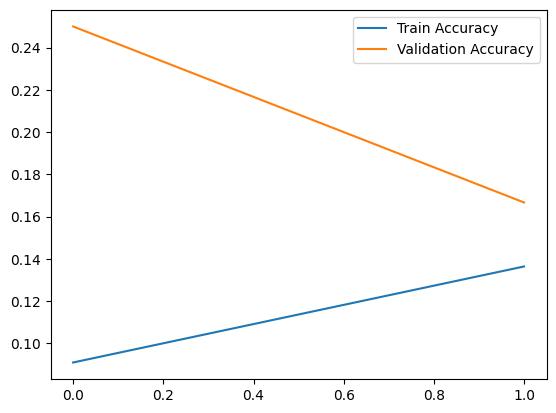

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


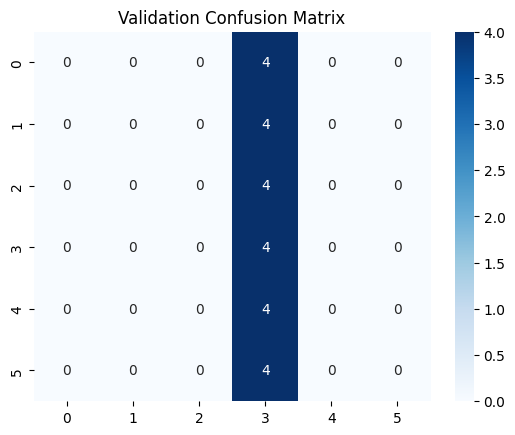

In [19]:
# Evaluate accuracy and loss graphs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Confusion matrix
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d')
plt.title("Validation Confusion Matrix")
plt.show()


In [11]:
# Classification report for validation set
val_classification_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=words)
print("Validation Classification Report:")
print(val_classification_report)

# Final test evaluation
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

test_accuracy = np.mean(y_test_true_classes == y_test_pred_classes)
print(f"Test accuracy: {test_accuracy}")

# Test set classification report
test_classification_report = classification_report(y_test_true_classes, y_test_pred_classes, target_names=words)
print("Test Classification Report:")
print(test_classification_report)

Validation Classification Report:
              precision    recall  f1-score   support

       Begin       0.50      0.25      0.33         4
      Choose       0.80      1.00      0.89         4
        Next       0.60      0.75      0.67         4
       Start       0.80      1.00      0.89         4
        Stop       0.67      1.00      0.80         4
         Web       1.00      0.25      0.40         4

    accuracy                           0.71        24
   macro avg       0.73      0.71      0.66        24
weighted avg       0.73      0.71      0.66        24

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Test accuracy: 0.3333333333333333
Test Classification Report:
              precision    recall  f1-score   support

       Begin       0.40      0.50      0.44         4
      Choose       0.29      0.50      0.36         4
        Next       0.00      0.00      0.00         4
       Start       0.50      0.50      0.50         4
        Stop       0.33      0.50      0.40         

SAVING THE MODEL

In [20]:

model_save_path = "lip_reading_model_effnet_final_01.keras"
model.save(model_save_path)
print(f"Model saved in Keras format to {model_save_path}")


Model saved in Keras format to lip_reading_model_effnet_final_01.keras


LOADING THE MODEL

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_save_path = "/content/drive/MyDrive/CV_Final Submission/lip_reading_model_effnet_final_58.33.keras"
# new2 = load_model(model_save_path)
new2 = load_model(model_save_path,compile=False)
print("Model loaded successfully.")

y_test_pred = new2.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

test_accuracy = np.mean(y_test_true_classes == y_test_pred_classes)
print(f"Test Accuracy: {test_accuracy}")

test_classification_report = classification_report(y_test_true_classes, y_test_pred_classes, target_names=words)
print("Test Classification Report:")
print(test_classification_report)
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=words, yticklabels=words)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model loaded successfully.
